# GSEF Prediction

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

In [ ]:
#Next: Finish copying and pasting the explanation -after adapting it- here. Useful to further clarify the steps.

## Imports & data loading

In [157]:
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

gsef_historical_selected= pd.read_csv('gsef_folder/historical_gsef.csv', parse_dates=['Date'], usecols= ["Date", "Close"])

In [99]:
gsef_historical_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4599 entries, 0 to 4598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4599 non-null   datetime64[ns]
 1   Close   4599 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 72.0 KB


In [3]:
y = gsef_historical_selected['Close'].values

In [4]:
#y

## Data splitting

In [5]:
train_data, test_data = gsef_historical_selected[0:int(len(gsef_historical_selected)*0.8)], gsef_historical_selected[int(len(gsef_historical_selected)*0.8):]

In [41]:
#len(train_data)

3679

In [7]:
# Load/split your data
y_train, y_test = train_test_split(y, train_size= len(train_data))

## Pre-modeling analysis

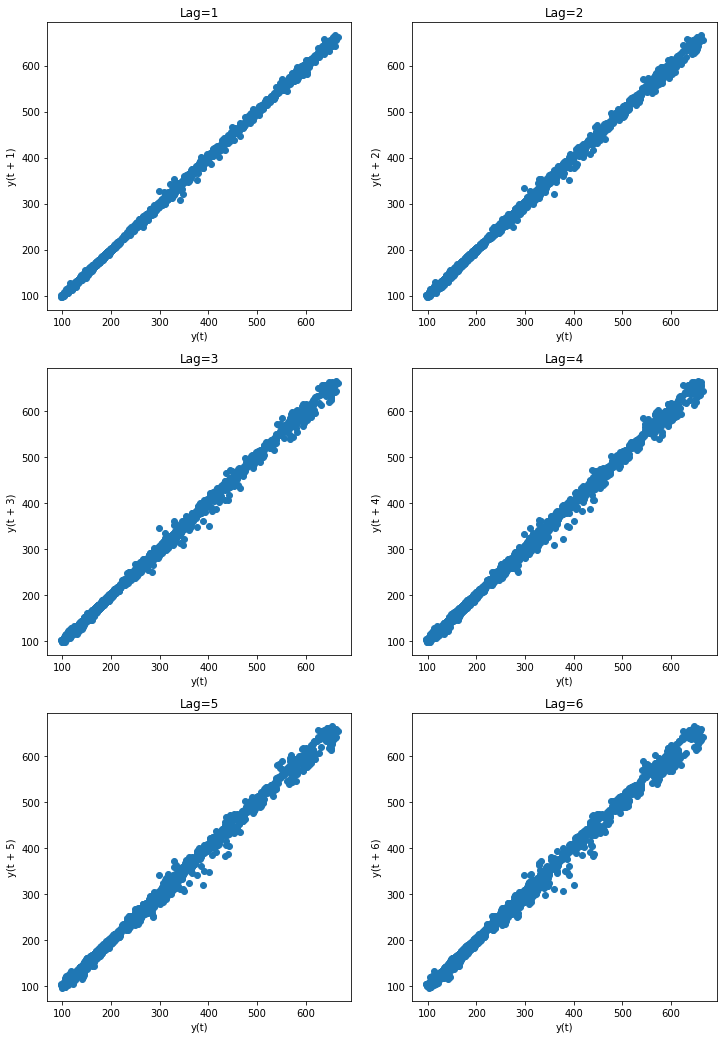

In [43]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('GSEF Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(gsef_historical_selected['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

## Estimating the differencing term

In [44]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


## Fitting our model

In [11]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14759.813, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14769.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14762.535, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14761.816, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14771.181, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14759.353, Time=1.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14759.264, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14761.186, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14760.021, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14760.342, Time=2.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=14760.469, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 8.224 seconds


In [12]:
#print(auto.order)

(0, 1, 2)


## Updating the model

In [46]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")
# Mean squared error: 28.692414878594857
# SMAPE: 0.8443963447520769

Mean squared error: 99.03610360573371
SMAPE: 0.9099875793897737


In [47]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5519
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -16523.951
Date:                Sun, 27 Mar 2022   AIC                          33055.901
Time:                        21:08:49   BIC                          33082.364
Sample:                             0   HQIC                         33065.130
                               - 5519                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0819      0.096      0.857      0.392      -0.105       0.269
ma.L1         -0.0242      0.008     -2.983      0.003      -0.040      -0.008
ma.L2          0.0266      0.008      3.201      0.001       0.010       0.043
sigma2        23.3637      0.026    899.364      0.000      23.313      23.415
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         446936913.71
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              26.88   Skew:                           -26.66
Prob(H) (two-sided):                  0.00   Kurtosis:                      1396.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Viewing forecasts

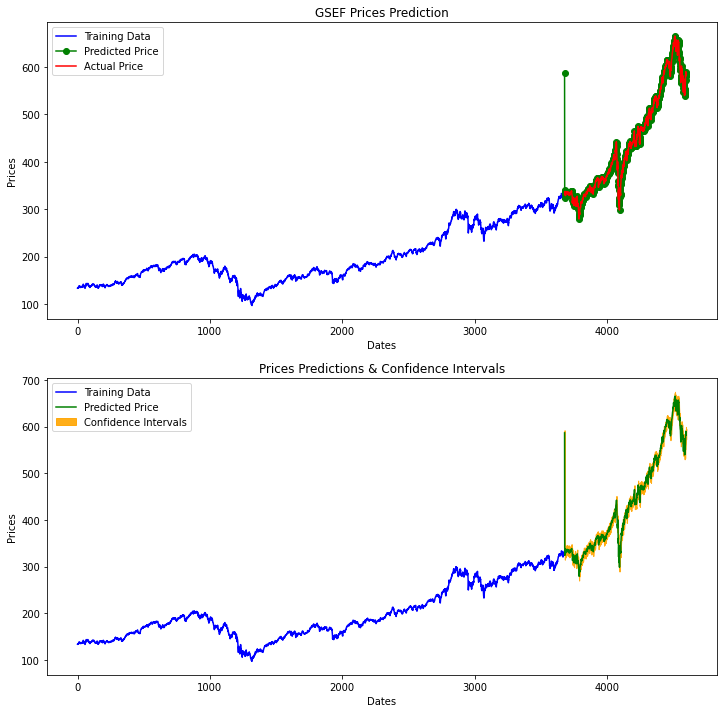

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('GSEF Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

## Predict the Price for the next 10 business days

In [144]:
## Predict the Priece for the next 10 business days
prediction= model.predict(start= len(gsef_historical_selected), end= len(gsef_historical_selected)+10, type= 'levels')

In [145]:
following_day= gsef_historical_selected.Date.iloc[-1]+ pd.DateOffset(1)

In [140]:
index_future_dates= pd.date_range(start= following_day, periods=10, freq='B')

prediction_df = pd.DataFrame(prediction, columns = ['Close'], index= pd.DatetimeIndex(index_future_dates)).reset_index(level=0)

prediction_df.rename(columns={'index': 'Date'}, inplace=True)

In [77]:
#prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10 non-null     datetime64[ns]
 1   Close   10 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 288.0 bytes


In [81]:
existing_with_prediction= pd.concat([gsef_historical_selected, prediction_df], ignore_index=True, sort=False)
#existing_with_prediction

,Date,Close
0,2004-01-01,133.550000
1,2004-01-02,134.020000
2,2004-01-05,134.810000
3,2004-01-06,134.500000
4,2004-01-07,134.510000
...,...,...
4604,2022-04-04,586.817892
4605,2022-04-05,586.899750
4606,2022-04-06,586.981608
4607,2022-04-07,587.063466


## Visualise the forecasts

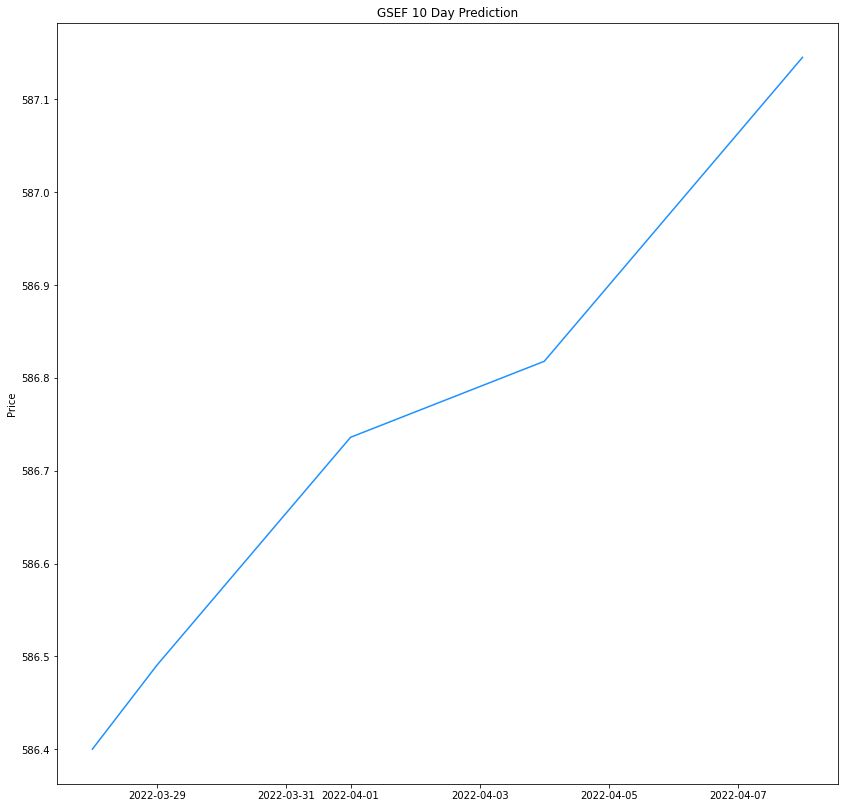

In [155]:
#plt.plot(existing_with_prediction['Date'][:-10], existing_with_prediction['Close'][:-10], color='crimson')

plt.figure(figsize=(14, 14))

plt.plot(existing_with_prediction['Date'][-10:], existing_with_prediction['Close'][-10:], color='dodgerblue')

plt.ylabel('Price')

plt.title('GSEF 10 Day Prediction')

plt.savefig('gsef_folder/gsef_10_day_prediction.png', dpi=100)

plt.show()

In [ ]:
# At the end: Publish all the work to my corresponding GitHub repositary and make the repositary public.